# Predict the likelihood of a loan default

Problem Statement

Background
    • If you've ever applied for a credit card or loan, you know that financial firms process your information before making a decision. This is because giving you a loan can have a serious financial impact on their business. But how do they make a decision? In this project, we will clean and prepare credit application data. After that, we will apply machine learning to reduce risk and ensure profitability. 

Objective
    • Reduce defaults and minimize risk by predicting the likelihood that a borrower will not repay their loan.

Scope
    • Product scope: Loans [e.g. Debt consolidation,Education, Medical, Personal & Venture ]

Business value 
    • An AI-based approach can predict someone is going to default, this may lead to intervention steps, such as sending earlier notices or rejecting loan applications.

# Import necessary Libararies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os 
import time
plt.style.use('ggplot')
import sweetviz as sw
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
import shap
from sklearn.metrics import precision_recall_curve, f1_score, auc
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from sklearn import tree, metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import *
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

# Explore the Credit Data 

The data we will use for our predictions of probability of default includes a application data (e.g. loan grade )and behavioral data (e.g. employment length) together.

    • In this dataset, each entry represents a person who takes a credit by a bank.
    • The target is: loan_status (0 or 1)
        ◦ 1 in case of default.
        ◦ 0 otherwise.
    • It is a binary classification problem.
    • The dataset is highly imbalanced.
    1. Read data with pandas 
    2. Check data for missing values 
    3. Explore variable types 
    4. Determine the dependent variable 
    5. Determine best predictors 
    6. Determine best linear transformations for modeling 
    7. Determine if any interactions make sense 

In [2]:
print("Load/Read the dataset and check the structure of first five rows of the dataset.")
df = pd.read_csv('cr_loan_data_.csv') 
df.head()

Load/Read the dataset and check the structure of first five rows of the dataset.


,loan_ID,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
0,1,21,9600,5,1000,11.14,0,0.10,2,0,...,0,0,1,0,0,0,0,0,1,0
1,2,25,9600,1,5500,12.87,1,0.57,3,1,...,0,0,0,1,0,0,0,0,1,0
2,3,23,65500,4,35000,15.23,1,0.53,2,0,...,0,0,0,1,0,0,0,0,1,0
3,4,24,54400,8,35000,14.27,1,0.55,4,0,...,0,0,0,1,0,0,0,0,0,1
4,5,21,9900,2,2500,7.14,1,0.25,2,0,...,1,1,0,0,0,0,0,0,1,0


In [3]:
# drop loan_ID
df.drop('loan_ID', axis = 1, inplace = True)

# Data Dictionary
    • person_age (numerical) refers to the age.
    • person_income (numerical) refers to the annual income.
    • person_home_ownership (categorical: 'MORTGAGE', 'RENT', 'OWN', 'OTHER').
    • person_emp_length (numerical) refers to the employment length (in years).
    • loan_intent (categorical: 'VENTURE', 'DEBTCONSOLIDATION', 'HOMEIMPROVEMENT', 'MEDICAL', 'EDUCATION', 'PERSONAL') refers to the loan purpose.
    • loan_grade (categorical: 'A', 'C', 'D', 'B', 'E', 'F','G'). 
    • loan_amnt (numerical) refers to the loan amount.
    • loan_int_rate (numerical) refers to the loan interest rate.
    • loan_percent_income (numerical).
    • cb_person_default_on_file (categorical: 'N', 'Y') refers to the historical default.
    • cb_person_cred_hist_length (numerical) refers to the credit history length.
Loan grades are set based on both the borrower’s credit profile and the nature of the contract. 'A' grade loans represent the lowest risk while 'E' grade loans are the riskiest.

In [4]:
print("Check the data shape(rows, columns). it has 29459 rows and 27 columns. That’s 27 features.")
df.shape

Check the data shape(rows, columns). it has 29459 rows and 27 columns. That’s 27 features.


(29459, 27)

# Exploratory Data Analysis

In [5]:
# Now we check the data types and other information.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29459 entries, 0 to 29458
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      29459 non-null  int64  
 1   person_income                   29459 non-null  int64  
 2   person_emp_length               29459 non-null  int64  
 3   loan_amnt                       29459 non-null  int64  
 4   loan_int_rate                   29459 non-null  float64
 5   loan_status                     29459 non-null  int64  
 6   loan_percent_income             29459 non-null  float64
 7   cb_person_cred_hist_length      29459 non-null  int64  
 8   person_home_ownership_MORTGAGE  29459 non-null  int64  
 9   person_home_ownership_OTHER     29459 non-null  int64  
 10  person_home_ownership_OWN       29459 non-null  int64  
 11  person_home_ownership_RENT      29459 non-null  int64  
 12  loan_intent_DEBTCONSOLIDATION   

In [6]:
# check for missing values
df.isnull().sum()

person_age                        0
person_income                     0
person_emp_length                 0
loan_amnt                         0
loan_int_rate                     0
loan_status                       0
loan_percent_income               0
cb_person_cred_hist_length        0
person_home_ownership_MORTGAGE    0
person_home_ownership_OTHER       0
person_home_ownership_OWN         0
person_home_ownership_RENT        0
loan_intent_DEBTCONSOLIDATION     0
loan_intent_EDUCATION             0
loan_intent_HOMEIMPROVEMENT       0
loan_intent_MEDICAL               0
loan_intent_PERSONAL              0
loan_intent_VENTURE               0
loan_grade_A                      0
loan_grade_B                      0
loan_grade_C                      0
loan_grade_D                      0
loan_grade_E                      0
loan_grade_F                      0
loan_grade_G                      0
cb_person_default_on_file_N       0
cb_person_default_on_file_Y       0
dtype: int64

In [7]:
print("The fact that we have all 0s means there is no missing data. Cleaning data is an important part of machine learning.")

The fact that we have all 0s means there is no missing data. Cleaning data is an important part of machine learning.


In [8]:
#Using df.describe(), describe the distribution of the numerical features.
pd.set_option('float_format', '{:.0f}'.format)
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
count,29459,29459,29459,29459,29459,29459,29459,29459,29459,29459,...,29459,29459,29459,29459,29459,29459,29459,29459,29459,29459
mean,28,65804,5,9584,11,0,0,6,0,0,...,0,0,0,0,0,0,0,0,1,0
std,6,51331,4,6314,3,0,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
min,20,4000,0,500,5,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
25%,23,38500,2,5000,8,0,0,3,0,0,...,0,0,0,0,0,0,0,0,1,0
50%,26,55000,4,8000,11,0,0,4,0,0,...,0,0,0,0,0,0,0,0,1,0
75%,30,79050,7,12250,13,0,0,8,1,0,...,0,1,1,0,0,0,0,0,1,0
max,84,2039784,41,35000,23,1,1,30,1,1,...,1,1,1,1,1,1,1,1,1,1


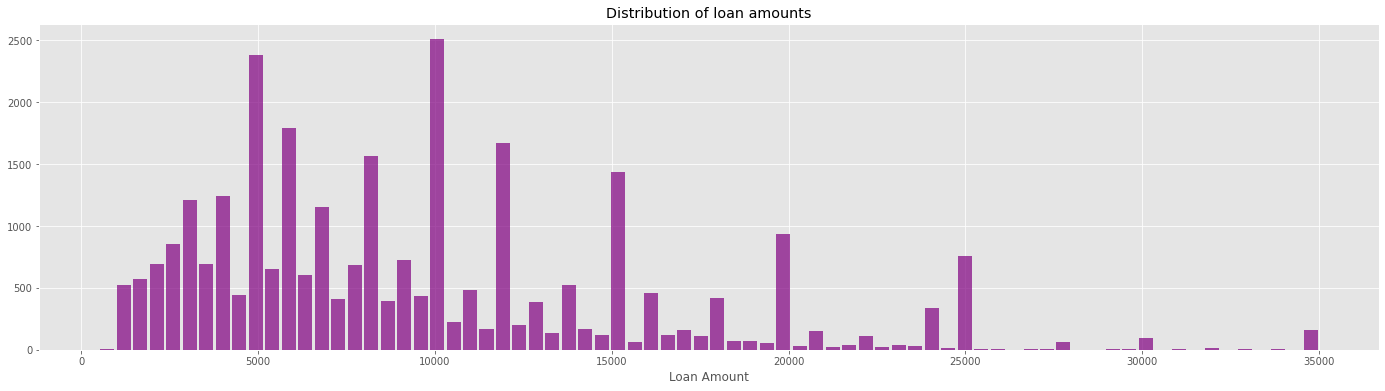

In [9]:
# Look at the distribution of loan amounts with a histogram
f, ax = plt.subplots(figsize = (24,6))
n, bins, patches = plt.hist(x=df['loan_amnt'], bins='auto', color='purple',alpha=0.7, rwidth=0.85)
plt.xlabel("Loan Amount")
plt.title("Distribution of loan amounts")
plt.show()

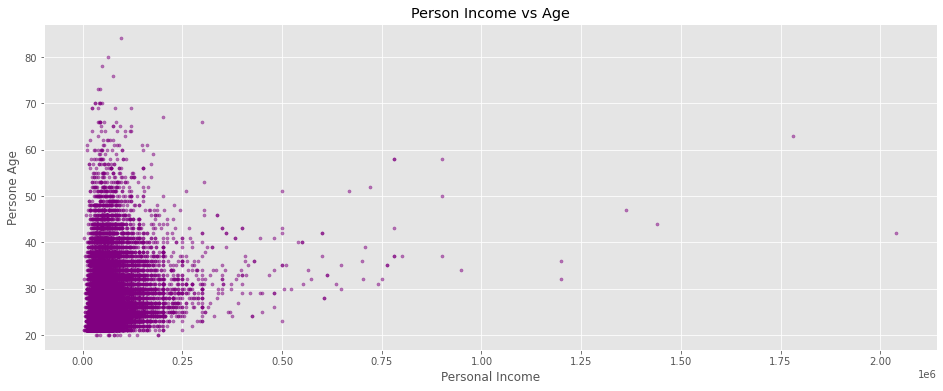

In [10]:
# Plot a scatter plot of income against age
f, ax = plt.subplots(figsize = (16,6))
plt.scatter(df['person_income'], df['person_age'],c='purple', alpha=0.5, s=10)
plt.xlabel('Personal Income')
plt.ylabel('Persone Age')
plt.title('Person Income vs Age')
plt.show()

As we can see the scatter plot above, there's a positive correlation with age and income, which could mean these older recipients are further along in their career and therefore earn higher salaries. There also appears to be an outlier in the data.

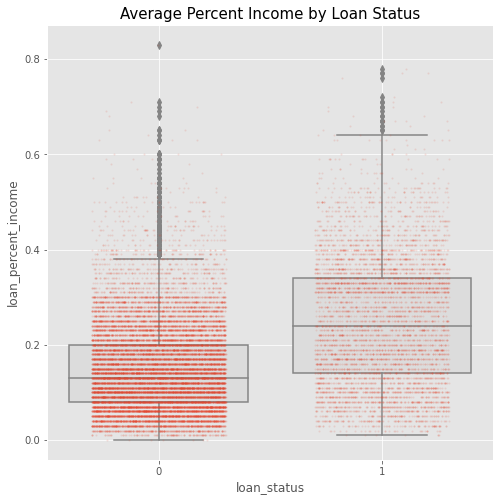

In [11]:
# Create a box plot of percentage income by loan status:
plt.figure(figsize=(8,8))
ax = sns.boxplot(y='loan_percent_income', x='loan_status', data=df, color="gainsboro")
sns.stripplot(y='loan_percent_income', x='loan_status', data=df, jitter=0.3, size=2, alpha=0.15)
ax.set_title('Average Percent Income by Loan Status', fontsize=15);
plt.grid(True)

It looks like the average percentage of income for defaults is higher. This could indicate those recipients have a debt-to-income ratio that's already too high.

# Outliers in Credit Data

Outliers are data points that exist far away from the majority of your data. This can happen due to several reasons, such as incorrect data recording to genuine rare occurrences.Either way you will often want to remove these values as they can negatively impact your models. An example of the negative effect can be seen here where an outlier is causing almost all of the scaled data to be squashed to the lower bound.

we'll explore in this project:IQR - Quantile based detection

FixedFormatter should only be used together with FixedLocator


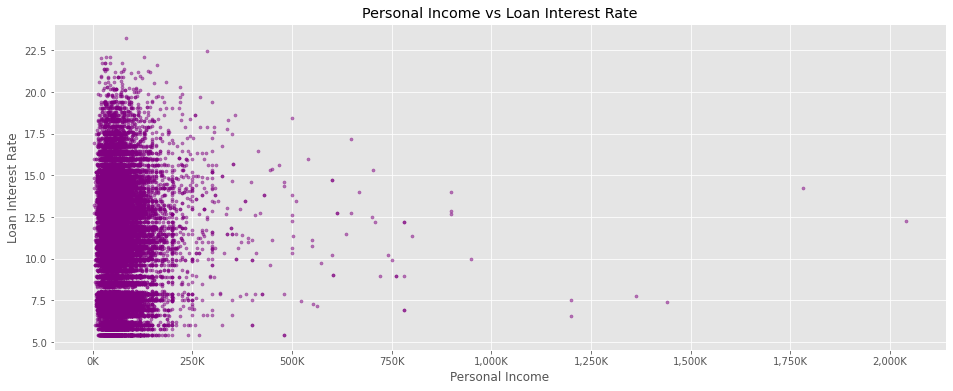

In [12]:
# Plot a scatter plot of income Loan interest Rate
f, ax = plt.subplots(figsize = (16,6))
plt.scatter(df['person_income'], df['loan_int_rate'],c='purple', alpha=0.5, s=10)
xlabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels)
plt.xlabel('Personal Income')
plt.ylabel('Loan Interest Rate')
plt.title('Personal Income vs Loan Interest Rate')
plt.show()

FixedFormatter should only be used together with FixedLocator


[Text(-250000.0, 0, '-250K'),
 Text(0.0, 0, '0K'),
 Text(250000.0, 0, '250K'),
 Text(500000.0, 0, '500K'),
 Text(750000.0, 0, '750K'),
 Text(1000000.0, 0, '1,000K'),
 Text(1250000.0, 0, '1,250K'),
 Text(1500000.0, 0, '1,500K'),
 Text(1750000.0, 0, '1,750K'),
 Text(2000000.0, 0, '2,000K'),
 Text(2250000.0, 0, '2,250K')]

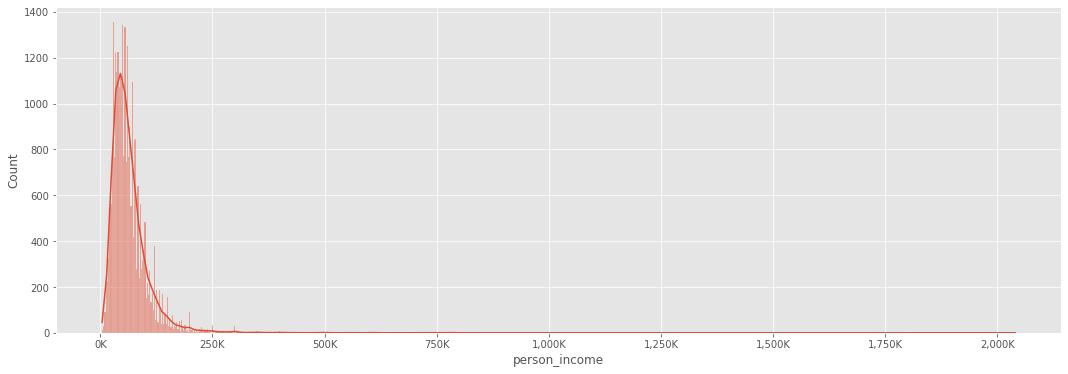

In [13]:
f, ax = plt.subplots(figsize = (18,6))
ax = sns.histplot(x=df['person_income'], kde=True)
xlabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels)

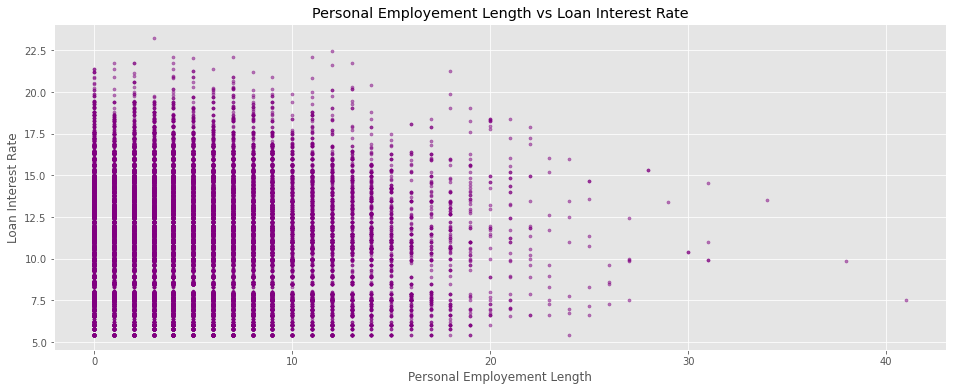

In [14]:
# Plot a scatter plot of Personal Employement Length against Loan Interest Rate:
f, ax = plt.subplots(figsize = (16,6))
plt.scatter(df['person_emp_length'], df['loan_int_rate'],c='purple', alpha=0.5, s=10)
plt.xlabel('Personal Employement Length')
plt.ylabel('Loan Interest Rate')
plt.title('Personal Employement Length vs Loan Interest Rate')
plt.show()

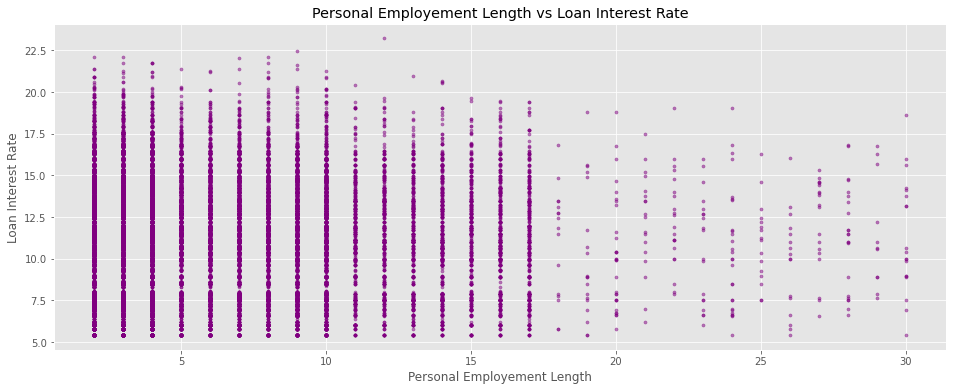

In [15]:
# Plot a scatter plot of Personal Employement Length against Loan Interest Rate:
f, ax = plt.subplots(figsize = (16,6))
plt.scatter(df['cb_person_cred_hist_length'], df['loan_int_rate'],c='purple', alpha=0.5, s=10)
plt.xlabel('Personal Employement Length')
plt.ylabel('Loan Interest Rate')
plt.title('Personal Employement Length vs Loan Interest Rate')
plt.show()

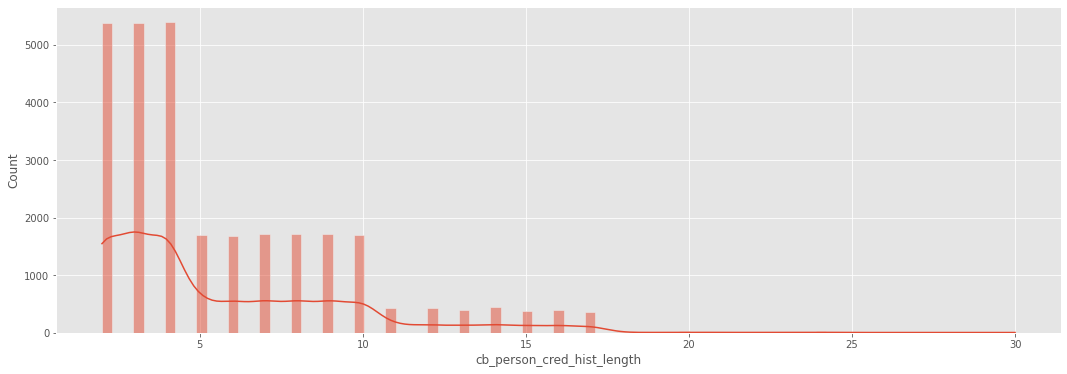

In [16]:
f, ax = plt.subplots(figsize = (18,6))
ax = sns.histplot(x=df['cb_person_cred_hist_length'], kde=True)

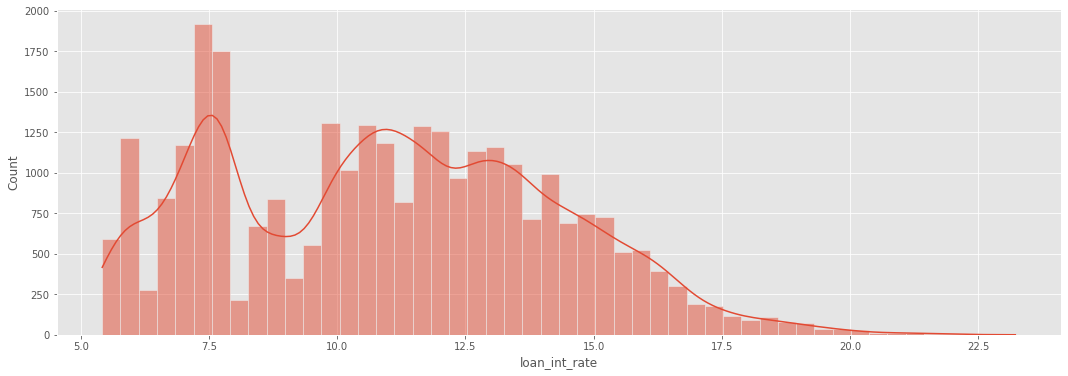

In [17]:
f, ax = plt.subplots(figsize = (18,6))
ax = sns.histplot(x=df['loan_int_rate'], kde=True)

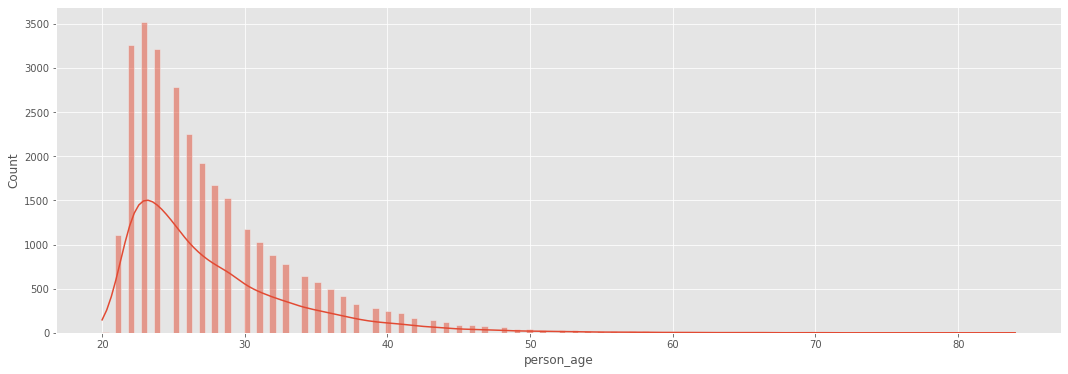

In [18]:
f, ax = plt.subplots(figsize = (18,6))
ax = sns.histplot(x=df['person_age'], kde=True)

In [19]:
def determine_outlier_thresholds_quant(dataframe, col_name, th1=0.25, th3=0.75):
    quartile1 = dataframe[col_name].quantile(th1)
    quartile3 = dataframe[col_name].quantile(th3)
    iqr = quartile3 - quartile1
    upper_limit = quartile3 + 1.5 * iqr
    lower_limit = quartile1 - 1.5 * iqr
    return lower_limit, upper_limit


In [20]:
quant_outlier = pd.DataFrame(determine_outlier_thresholds_quant(df, df.columns))
pd.set_option('float_format', '{:.4f}'.format)
quant_outlier.T

,0,1
person_age,12.5000,40.5000
person_income,-22325.0000,139875.0000
person_emp_length,-5.5000,14.5000
loan_amnt,-5875.0000,23125.0000
loan_int_rate,-0.4550,21.8250
loan_status,0.0000,0.0000
loan_percent_income,-0.1200,0.4400
cb_person_cred_hist_length,-4.5000,15.5000
person_home_ownership_MORTGAGE,-1.5000,2.5000
person_home_ownership_OTHER,0.0000,0.0000


In [21]:
df_quant = df

In [22]:
df_quant = df_quant[(df_quant['person_age'] < 41) & (df['person_age'] > 11)]

In [23]:
df_quant = df_quant[df_quant['person_income'] < 139875]

In [24]:
df_quant = df_quant[df_quant['person_emp_length'] < 15]

In [25]:
df_quant = df_quant[df_quant['loan_amnt'] < 23125]

In [26]:
df_quant = df_quant[df_quant['loan_int_rate'] < 22]

In [27]:
df_quant = df_quant[df_quant['cb_person_cred_hist_length'] < 16]

In [28]:
pd.set_option('float_format', '{:.0f}'.format)
df_quant.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_N,cb_person_default_on_file_Y
count,24808,24808,24808,24808,24808,24808,24808,24808,24808,24808,...,24808,24808,24808,24808,24808,24808,24808,24808,24808,24808
mean,26,56693,4,8503,11,0,0,5,0,0,...,0,0,0,0,0,0,0,0,1,0
std,4,26292,3,4924,3,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
min,20,4080,0,500,5,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
25%,23,36074,2,5000,8,0,0,3,0,0,...,0,0,0,0,0,0,0,0,1,0
50%,25,52000,4,7500,11,0,0,4,0,0,...,0,0,0,0,0,0,0,0,1,0
75%,29,72000,6,12000,13,0,0,7,1,0,...,0,1,1,0,0,0,0,0,1,0
max,40,139200,14,23000,22,1,1,15,1,1,...,1,1,1,1,1,1,1,1,1,1


In [29]:
df.shape

(29459, 27)

In [30]:
df_quant.shape

(24808, 27)

FixedFormatter should only be used together with FixedLocator


[Text(-250000.0, 0, '-250K'),
 Text(0.0, 0, '0K'),
 Text(250000.0, 0, '250K'),
 Text(500000.0, 0, '500K'),
 Text(750000.0, 0, '750K'),
 Text(1000000.0, 0, '1,000K'),
 Text(1250000.0, 0, '1,250K'),
 Text(1500000.0, 0, '1,500K'),
 Text(1750000.0, 0, '1,750K'),
 Text(2000000.0, 0, '2,000K'),
 Text(2250000.0, 0, '2,250K')]

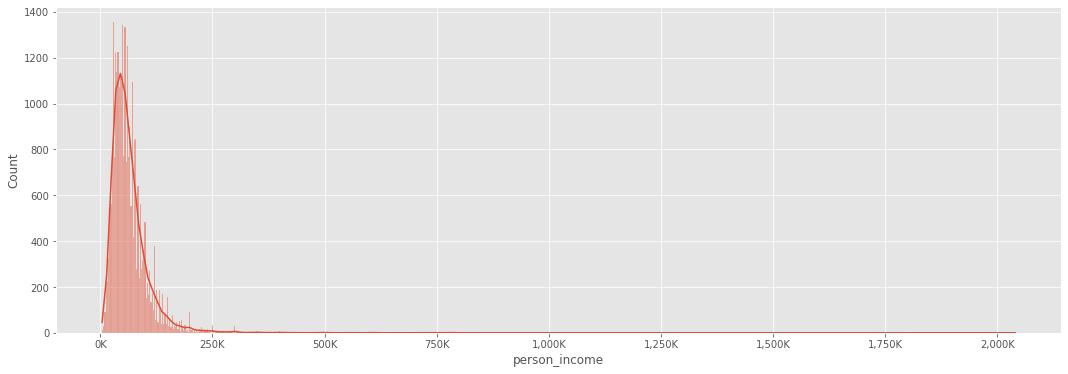

In [31]:
f, ax = plt.subplots(figsize = (18,6))
ax = sns.histplot(x=df['person_income'], kde=True)
xlabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels)

FixedFormatter should only be used together with FixedLocator


[Text(-20000.0, 0, '-20K'),
 Text(0.0, 0, '0K'),
 Text(20000.0, 0, '20K'),
 Text(40000.0, 0, '40K'),
 Text(60000.0, 0, '60K'),
 Text(80000.0, 0, '80K'),
 Text(100000.0, 0, '100K'),
 Text(120000.0, 0, '120K'),
 Text(140000.0, 0, '140K'),
 Text(160000.0, 0, '160K')]

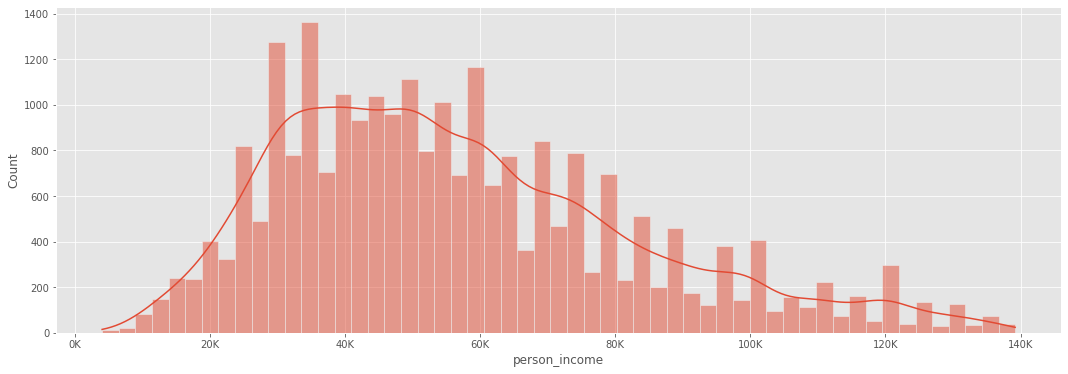

In [32]:
f, ax = plt.subplots(figsize = (18,6))
ax = sns.histplot(x=df_quant['person_income'], kde=True)
xlabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
ax.set_xticklabels(xlabels)

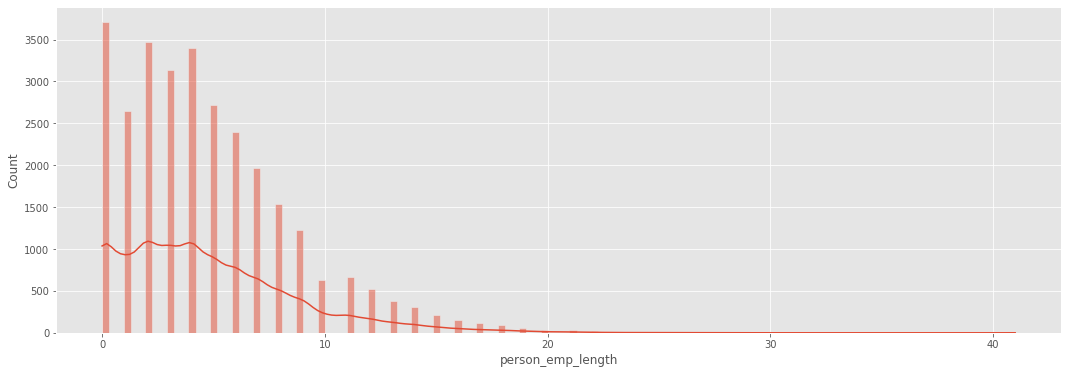

In [33]:
f, ax = plt.subplots(figsize = (18,6))
ax = sns.histplot(x=df['person_emp_length'], kde=True)

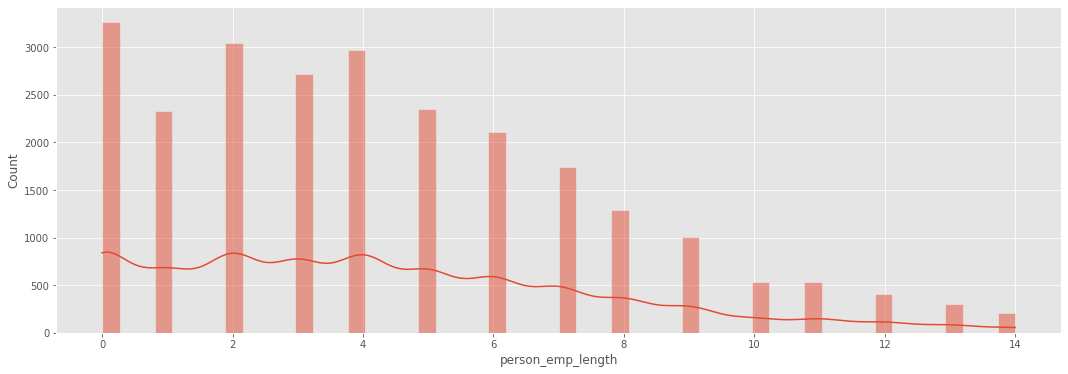

In [34]:
f, ax = plt.subplots(figsize = (18,6))
ax = sns.histplot(x=df_quant['person_emp_length'], kde=True)

In [35]:
df_quant.columns

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_cred_hist_length', 'person_home_ownership_MORTGAGE',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'loan_grade_A', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D',
       'loan_grade_E', 'loan_grade_F', 'loan_grade_G',
       'cb_person_default_on_file_N', 'cb_person_default_on_file_Y'],
      dtype='object')

Text(0.5, 1.0, 'Credit Data Heatmap')

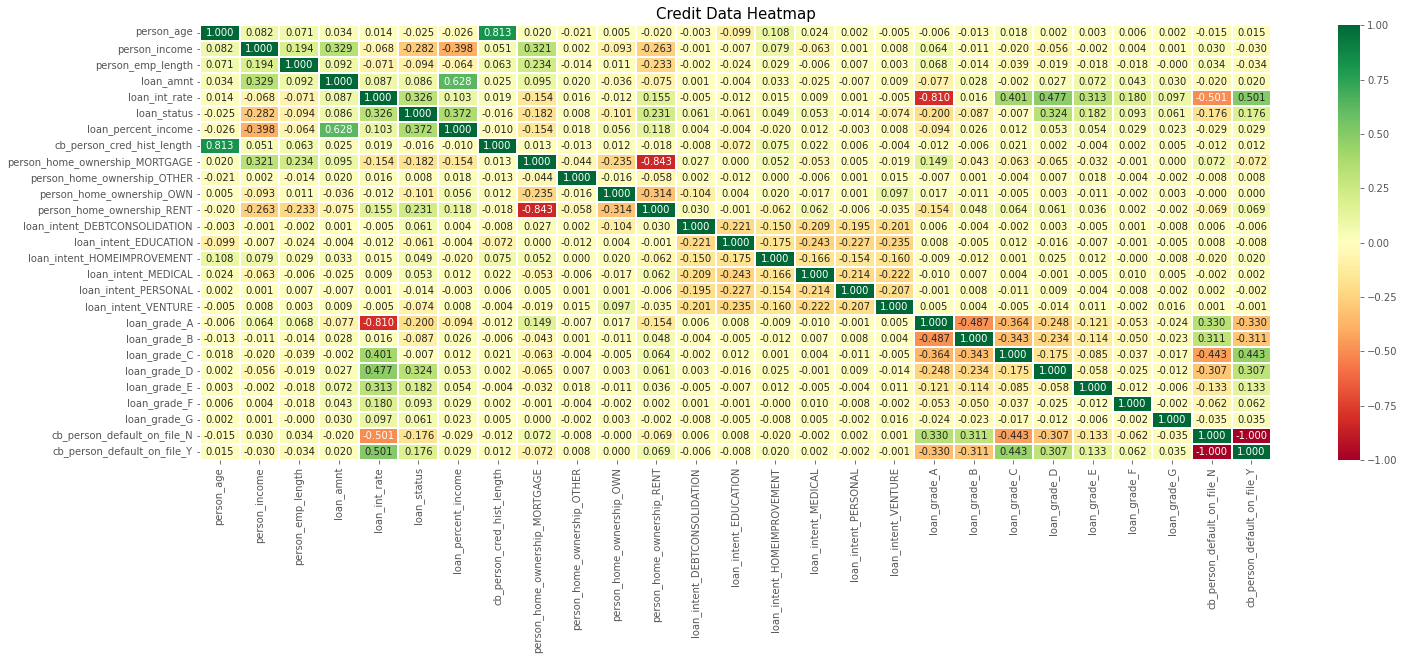

In [36]:
# Make a heatmap of the data 
plt.figure(figsize=(24,8)) # ensure that the Matplotlib plot is big enough
sns.heatmap(df_quant.corr(), linewidths=.4, annot=True, fmt=".3f", cmap='RdYlGn')
plt.title('Credit Data Heatmap', fontsize=15)



Some interesting observations:

age and income/person_cred_hist_length are very highly correlated. Because the older recipients are further along in their career and therefore earn higher salaries and longer credit history. 

income and loan grade A['A' grade loans represent the lowest risk] are both highly negatively correlated with loan status. The data suggests that these features have a negative impact on the predicted variable.


# Target Variable Visualization: Loan Status

The class labels for the target column (loan_status) in our data is imbalance as indicated in the bar chart below.

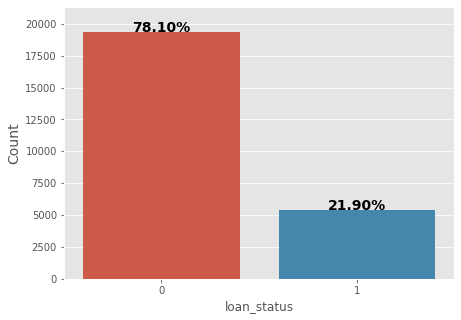

In [86]:
#df_quant.loan_status.plot(kind='hist')

import matplotlib.pyplot as plt
import seaborn as sns 

total = len(df_quant)
plt.figure(figsize=(7,5))
g = sns.countplot(x='loan_status', data=df_quant)
g.set_ylabel('Count', fontsize=14)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 1.5,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14, fontweight='bold')
plt.margins(y=0.1)
plt.show()

In [87]:
#Now, we check the count of the target variable.
df_quant["loan_status"].value_counts()

0    19375
1     5433
Name: loan_status, dtype: int64

In [38]:
# Let's define/select our features:
features = ['person_age', 'person_income', 'person_emp_length',
       'loan_amnt', 'loan_int_rate', 'loan_percent_income',
       'cb_person_cred_hist_length', 'person_home_ownership_MORTGAGE',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'loan_grade_A', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D',
       'loan_grade_E', 'loan_grade_F', 'loan_grade_G',
       'cb_person_default_on_file_N', 'cb_person_default_on_file_Y']

# And, Now let's define X and y:
X = df[features]
y = df.loan_status

#Train/Test Split

Now, let's split our data (X) into training and testing splits, without letting a model learn anything about the test split.

let's have 75/25 Train/Test split:

#Split Data

Section Goals

    Create a random split in dataset
    Set random seed for repeatability
    Use stratify to create an unbiased 



In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.25, stratify=y,
                                                    random_state=1981)

# Scaling and Transformation: Standardization

Standardization finds the mean of our data and centers the distribution around it, calculating the number of standard deviations away from the mean each point is. The number of standard deviations are then used as our new values. This centers the data around 0 but technically has no limit to the maximum and minimum values.

In [40]:
# Import StandardScaler:
from sklearn.preprocessing import StandardScaler

# Instantiate StandardScaler:
scaler = StandardScaler()

# Fit & transform  scaler to the data:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Modelling

1. Logistic Regression (Baseline Model) :
    
1.1 Fitting a Logistic Regression Model: Imbalanced Target Variable

This is our simplest technique. This can be considered the model to beat for all other subsequent, more complicated modeling applications.

Section Goals

    Train Logistic Regression model, using scikit-learn on the normalized dataset
    Make predctions on test dataset
    Evaluate model performance metrics:Confusion Matrix ,Accuracy,precision,recall,f1-score,ROC Curve -AUC
    Create visualizations of predictions

In [41]:
# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

# Import confusion_matrix
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve, f1_score, auc
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from sklearn import tree, metrics

In [42]:
# Declare a variable called logreg_i_b, and assign it: LogisticRegression:
logreg_i_b = LogisticRegression(random_state=1981)

# Call fit() on logreg_i_b:
logreg_i_b.fit(X_train, y_train)

# Call predict() on entr_model with X_test passed to it, and assign the result to a variable y_pred_i_b 
y_pred_i_b = logreg_i_b.predict(X_test)

In [43]:
# Create predictions of probability for loan status using test data
preds_i_b = logreg_i_b.predict_proba(X_test)

# Create dataframes of first 20 predictions, and first 20 true labels
preds_df_i_b = pd.DataFrame(preds_i_b[:,1][0:20], columns = ['prob_default'])
true_df_i_b = y_test.head(20)

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df_i_b.reset_index(drop = True), preds_df_i_b], axis = 1))

    loan_status  prob_default
0             0             1
1             1             1
2             0             0
3             0             0
4             0             0
5             1             0
6             0             0
7             0             0
8             1             0
9             0             0
10            0             0
11            0             0
12            0             1
13            0             0
14            0             0
15            1             1
16            0             0
17            0             0
18            0             0
19            0             0


In [44]:
# Create a dataframe for the probabilities of default
preds_df_i_b = pd.DataFrame(preds_i_b[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
preds_df_i_b['loan_status'] = preds_df_i_b['prob_default'].apply(lambda x: 1 if x > 0.50 else 0)

print("Logistic Regression Model - Imbalanced")
print("Accuracy: {:0.5f}".format(metrics.accuracy_score(y_test,y_pred_i_b) *100), "%")
print('********************************************************')

# Print the row counts for each loan status
print(preds_df_i_b['loan_status'].value_counts())
print('********************************************************')
# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df_i_b['loan_status'], target_names=target_names, digits=6))

Logistic Regression Model - Imbalanced
Accuracy: 86.58520 %
********************************************************
0    6215
1    1150
Name: loan_status, dtype: int64
********************************************************
              precision    recall  f1-score   support

 Non-Default   0.883025  0.954601  0.917419      5749
     Default   0.773043  0.550124  0.642805      1616

    accuracy                       0.865852      7365
   macro avg   0.828034  0.752362  0.780112      7365
weighted avg   0.858893  0.865852  0.857164      7365



In [45]:
print('Logistic Regression Model - Imabalanced: confusion_matrix')
print('\n')
print(pd.crosstab(y_test.ravel(), y_pred_i_b.ravel(), rownames = ['True'], colnames = ['Predicted'], margins = True))

Logistic Regression Model - Imabalanced: confusion_matrix


Predicted     0     1   All
True                       
0          5488   261  5749
1           727   889  1616
All        6215  1150  7365


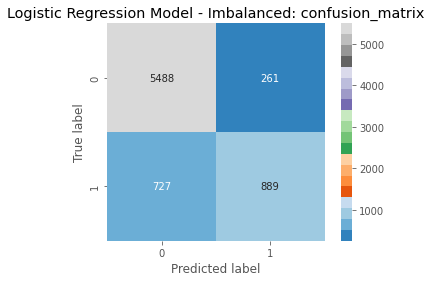

In [46]:
mat = confusion_matrix(y_test, y_pred_i_b)
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap='tab20c')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Logistic Regression Model - Imbalanced: confusion_matrix');

Logistic Regression model - Imabalnced - AUC: 87.59269 %


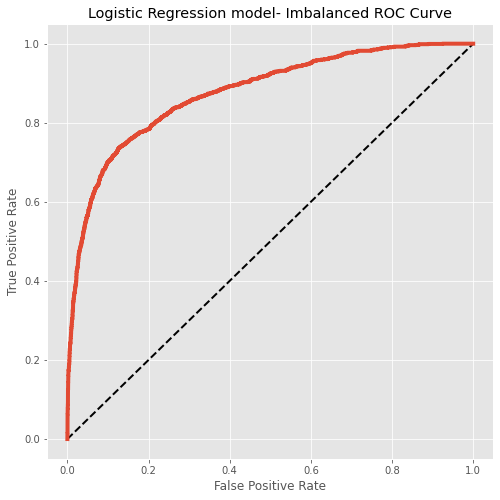

In [47]:
# Compute predicted probabilities: y_pred_prob:
y_pred_prob_i = logreg_i_b.predict_proba(X_test)[:,1]

print("Logistic Regression model - Imabalnced - AUC: {:0.5f}".format(roc_auc_score(y_test, y_pred_prob_i) * 100), "%")

# Generate ROC curve values: fpr, tpr, thresholds:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_i)
# Plot ROC curve:
plt.subplots(figsize = (8,8))
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.plot(fpr, tpr, label='Logistic Regression model', linewidth=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression model- Imbalanced ROC Curve')
plt.grid(True)
plt.show();

# Calculating AUC

The AUC value assesses how well a model can order observations from low probability to be target to high probability to be target. In Python, the roc_auc_score function can be used to calculate the AUC of the model. It takes the true values of the target and the predictions as arguments.

# 2. Random Forests:
2.1 Fitting a Random Forests Model: Imbalanced Target Variable

Section Goals

    Train Random Forest model, using scikit-learn on the normalized dataset
    Make predctions on test dataset
    Evaluate model performance metrics:Confusion Matrix ,Accuracy,precision,recall,f1-score,ROC Curve -AUC
    Create visualizations of predictions


In [48]:
from sklearn.ensemble import RandomForestClassifier

# Declare a variable called rf_i_b, and assign it: RandomForestClassifier:
rf_i_b = RandomForestClassifier(random_state = 1981)

# Call fit() on rf_i_b:
rf_i_b.fit(X_train, y_train)

# Call predict() on entr_model with X_test passed to it, and assign the result to a variable y_pred_i_b 
y_pred_i_b = rf_i_b.predict(X_test)

In [49]:
# Create predictions of probability for loan status using test data
preds_i_b = rf_i_b.predict_proba(X_test)

# Create dataframes of first 20 predictions, and first 20 true labels
preds_df_i_b = pd.DataFrame(preds_i_b[:,1][0:20], columns = ['prob_default'])
true_df_i_b = y_test.head(20)

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df_i_b.reset_index(drop = True), preds_df_i_b], axis = 1))

    loan_status  prob_default
0             0             0
1             1             1
2             0             0
3             0             0
4             0             0
5             1             1
6             0             0
7             0             0
8             1             1
9             0             0
10            0             0
11            0             0
12            0             0
13            0             0
14            0             0
15            1             1
16            0             0
17            0             0
18            0             0
19            0             0


In [50]:
# Run this block for model evaluation metrics 
print("Random Forests Model - Imbalanced")
print("Accuracy: {:0.5f}".format(metrics.accuracy_score(y_test,y_pred_i_b) *100), "%")
print('\n')
print("Random Forests Model - Imbalanced: classification report")
print(classification_report(y_test, y_pred_i_b, digits=6))

Random Forests Model - Imbalanced
Accuracy: 93.31976 %


Random Forests Model - Imbalanced: classification report
              precision    recall  f1-score   support

           0   0.924705  0.995477  0.958787      5749
           1   0.977891  0.711634  0.823782      1616

    accuracy                       0.933198      7365
   macro avg   0.951298  0.853556  0.891285      7365
weighted avg   0.936375  0.933198  0.929165      7365



In [51]:
print('Random Forests Model - Imabalanced: confusion_matrix')
print('\n')
print(pd.crosstab(y_test.ravel(), y_pred_i_b.ravel(), rownames = ['True'], colnames = ['Predicted'], margins = True))

Random Forests Model - Imabalanced: confusion_matrix


Predicted     0     1   All
True                       
0          5723    26  5749
1           466  1150  1616
All        6189  1176  7365


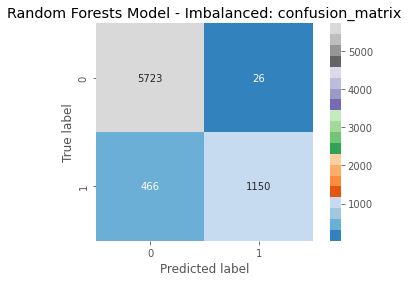

In [52]:
mat = confusion_matrix(y_test, y_pred_i_b)
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap='tab20c')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Random Forests Model - Imbalanced: confusion_matrix');

Random Forests model - Imabalnced - AUC: 93.68477 %


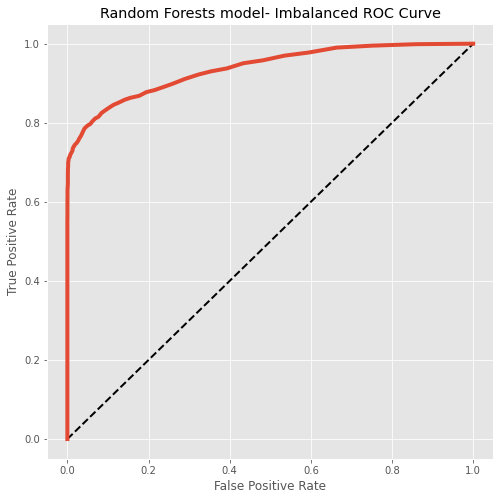

In [53]:
# Compute predicted probabilities: y_pred_prob:
y_pred_prob_i = rf_i_b.predict_proba(X_test)[:,1]

print("Random Forests model - Imabalnced - AUC: {:0.5f}".format(roc_auc_score(y_test, y_pred_prob_i) * 100), "%")

# Generate ROC curve values: fpr, tpr, thresholds:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_i)
# Plot ROC curve:
plt.subplots(figsize = (8,8))
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.plot(fpr, tpr, label='Random Forests model', linewidth=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forests model- Imbalanced ROC Curve')
plt.grid(True)
plt.show();

# Calculating AUC

The AUC value assesses how well a model can order observations from low probability to be target to high probability to be target. In Python, the roc_auc_score function can be used to calculate the AUC of the model. It takes the true values of the target and the predictions as arguments.

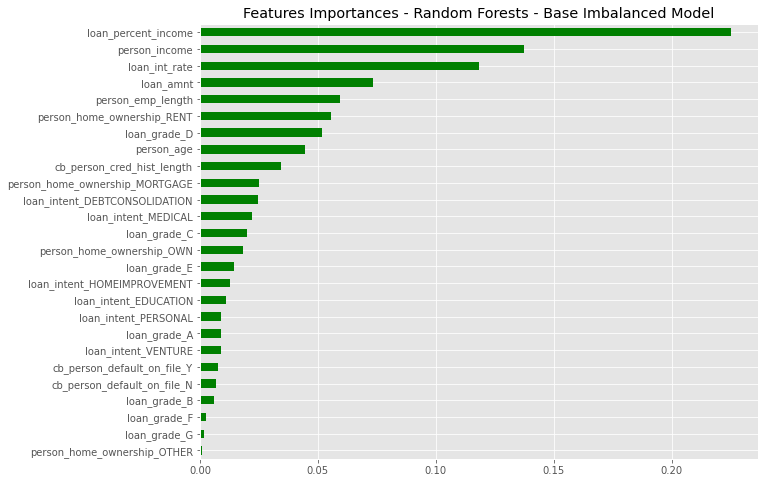

In [91]:
# First, let's create a pd.Series of features importances
importances_rf_i_b = pd.Series(data=rf_i_b.feature_importances_, index=X.columns)

# Sort importances
importances_sorted = importances_rf_i_b.sort_values()

# Draw a horizontal barplot of importances_sorted
plt.figure(figsize=(10, 8))
importances_sorted.plot(kind='barh', color='green')
plt.title('Features Importances - Random Forests - Base Imbalanced Model')
plt.grid(True)
plt.show()

In this case, the most important variable is loan_percent_income,person_income,loan_int_rate,loan_amnt and person_emp_length

# 3. XGBoost:
3.1 Fitting a XGBoost Model: Imbalanced Target Variable

Section Goals

    Train XGBoost model, using scikit-learn on the normalized dataset
    Make predctions on test dataset
    Evaluate model performance metrics:Confusion Matrix ,Accuracy,precision,recall,f1-score,ROC Curve -AUC
    Create visualizations of predictions


In [55]:
import xgboost as xgb

# Declare a variable called xgb_i_b, and assign it: XGBClassifier:
xgb_i_b = xgb.XGBClassifier(seed=1981, eval_metric='mlogloss', use_label_encoder=False)

# Call fit() on xgb_i_b:
xgb_i_b.fit(X_train, y_train)

# Call predict() on entr_model with X_test passed to it, and assign the result to a variable y_pred_i_b 
y_pred_i_b = xgb_i_b.predict(X_test)

In [56]:
# Create predictions of probability for loan status using test data
preds_i_b = xgb_i_b.predict_proba(X_test)

# Create dataframes of first 20 predictions, and first 20 true labels
preds_df_i_b = pd.DataFrame(preds_i_b[:,1][0:20], columns = ['prob_default'])
true_df_i_b = y_test.head(20)

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df_i_b.reset_index(drop = True), preds_df_i_b], axis = 1))

    loan_status  prob_default
0             0             0
1             1             1
2             0             0
3             0             0
4             0             0
5             1             1
6             0             0
7             0             0
8             1             1
9             0             0
10            0             0
11            0             0
12            0             1
13            0             0
14            0             0
15            1             1
16            0             0
17            0             0
18            0             0
19            0             0


In [57]:
# Run this block for model evaluation metrics 
print("XGBoost Model - Imbalanced")
print("Accuracy: {:0.5f}".format(metrics.accuracy_score(y_test,y_pred_i_b) *100), "%")
print('\n')
print("XGBoost Model - Imbalanced: classification report")
print(classification_report(y_test, y_pred_i_b, digits=6))

XGBoost Model - Imbalanced
Accuracy: 93.48269 %


XGBoost Model - Imbalanced: classification report
              precision    recall  f1-score   support

           0   0.931390  0.989389  0.959514      5749
           1   0.951510  0.740718  0.832985      1616

    accuracy                       0.934827      7365
   macro avg   0.941450  0.865054  0.896250      7365
weighted avg   0.935805  0.934827  0.931752      7365



In [58]:
# Create a dataframe for the probabilities of default
preds_df_i_b = pd.DataFrame(preds_i_b[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
preds_df_i_b['loan_status'] = preds_df_i_b['prob_default'].apply(lambda x: 1 if x > 0.50 else 0)

print("XGBoost Model - Imbalanced")
print("Accuracy: {:0.5f}".format(metrics.accuracy_score(y_test,y_pred_i_b) *100), "%")
print('********************************************************')

# Print the row counts for each loan status
print(preds_df_i_b['loan_status'].value_counts())
print('********************************************************')
# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df_i_b['loan_status'], target_names=target_names, digits=6))

XGBoost Model - Imbalanced
Accuracy: 93.48269 %
********************************************************
0    6107
1    1258
Name: loan_status, dtype: int64
********************************************************
              precision    recall  f1-score   support

 Non-Default   0.931390  0.989389  0.959514      5749
     Default   0.951510  0.740718  0.832985      1616

    accuracy                       0.934827      7365
   macro avg   0.941450  0.865054  0.896250      7365
weighted avg   0.935805  0.934827  0.931752      7365



In [59]:
print('XGBoost Model - Imabalanced: confusion_matrix')
print('\n')
print(pd.crosstab(y_test.ravel(), y_pred_i_b.ravel(), rownames = ['True'], colnames = ['Predicted'], margins = True))

XGBoost Model - Imabalanced: confusion_matrix


Predicted     0     1   All
True                       
0          5688    61  5749
1           419  1197  1616
All        6107  1258  7365


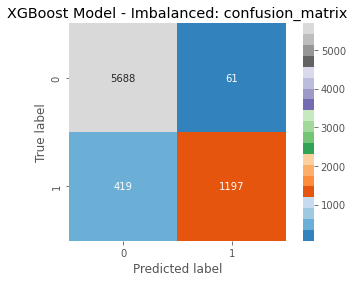

In [60]:
mat = confusion_matrix(y_test, y_pred_i_b)
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap='tab20c')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('XGBoost Model - Imbalanced: confusion_matrix');

XGBoost model - Imabalnced - AUC: 95.03921 %


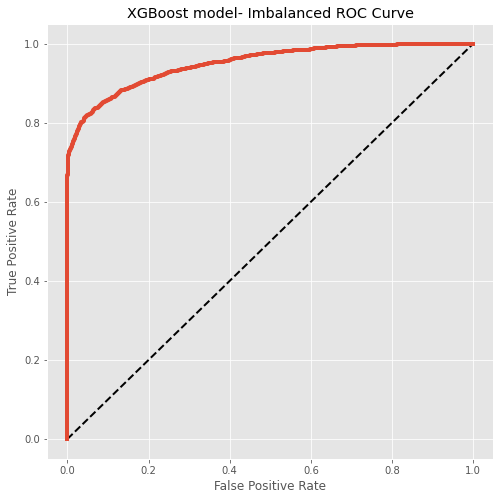

In [61]:
# Compute predicted probabilities: y_pred_prob:
y_pred_prob_i = xgb_i_b.predict_proba(X_test)[:,1]

print("XGBoost model - Imabalnced - AUC: {:0.5f}".format(roc_auc_score(y_test, y_pred_prob_i) * 100), "%")

# Generate ROC curve values: fpr, tpr, thresholds:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_i)
# Plot ROC curve:
plt.subplots(figsize = (8,8))
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.plot(fpr, tpr, label='XGBoost model', linewidth=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost model- Imbalanced ROC Curve')
plt.grid(True)
plt.show();

# Calculating AUC
The AUC value assesses how well a model can order observations from low probability to be target to high probability to be target. In Python, the roc_auc_score function can be used to calculate the AUC of the model. It takes the true values of the target and the predictions as arguments.

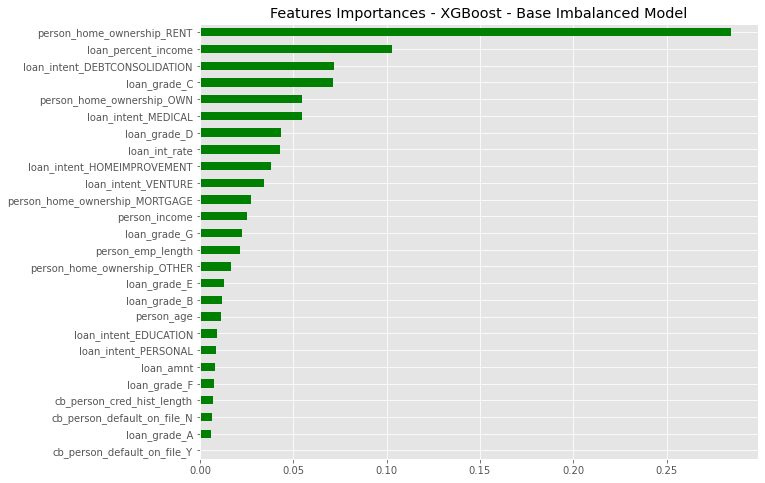

In [62]:
# First, let's create a pd.Series of features importances
importances_xgb_i_b = pd.Series(data=xgb_i_b.feature_importances_, index=X.columns)

# Sort importances
importances_sorted = importances_xgb_i_b.sort_values()

# Draw a horizontal barplot of importances_sorted
plt.figure(figsize=(10, 8))
importances_sorted.plot(kind='barh', color='green')
plt.title('Features Importances - XGBoost - Base Imbalanced Model')
plt.grid(True)
plt.show()

In this case, the most important variable is person_home_ownership_RENT,loan_percent_income,loan_intent_DEBTCONSOLIDATION and loan_grade_C

# 4. LightGBM:
4.1 Fitting a LightGBM Model: Imbalanced Target Variable

Section Goals

    Train LightGBM model, using scikit-learn on the normalized dataset
    Make predctions on test dataset
    Evaluate model performance metrics:Confusion Matrix ,Accuracy,precision,recall,f1-score,ROC Curve -AUC
    Create visualizations of predictions


In [63]:
# Import necessary modules
import lightgbm as lgb

# Declare a variable called lgb_i_b, and assign it: LGBMClassifier:
lgb_i_b = lgb.LGBMClassifier(random_state=1981)

# Call fit() on xgb_i_b:
lgb_i_b.fit(X_train, y_train)

# Call predict() on entr_model with X_test passed to it, and assign the result to a variable y_pred_i_b 
y_pred_i_b = lgb_i_b.predict(X_test)

In [64]:
# Create predictions of probability for loan status using test data
preds_i_b = lgb_i_b.predict_proba(X_test)

# Create dataframes of first 20 predictions, and first 20 true labels
preds_df_i_b = pd.DataFrame(preds_i_b[:,1][0:20], columns = ['prob_default'])
true_df_i_b = y_test.head(20)

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df_i_b.reset_index(drop = True), preds_df_i_b], axis = 1))

    loan_status  prob_default
0             0             0
1             1             1
2             0             0
3             0             0
4             0             0
5             1             1
6             0             0
7             0             0
8             1             1
9             0             0
10            0             0
11            0             0
12            0             0
13            0             0
14            0             0
15            1             1
16            0             0
17            0             0
18            0             0
19            0             0


In [65]:
# Run this block for model evaluation metrics 
print("LightGBM Model - Imbalanced")
print("Accuracy: {:0.5f}".format(metrics.accuracy_score(y_test,y_pred_i_b) *100), "%")
print('\n')
print("LightGBM Model - Imbalanced: classification report")
print(classification_report(y_test, y_pred_i_b, digits=6))

LightGBM Model - Imbalanced
Accuracy: 93.71351 %


LightGBM Model - Imbalanced: classification report
              precision    recall  f1-score   support

           0   0.929337  0.995130  0.961109      5749
           1   0.976840  0.730817  0.836106      1616

    accuracy                       0.937135      7365
   macro avg   0.953089  0.862973  0.898607      7365
weighted avg   0.939760  0.937135  0.933681      7365



In [66]:
# Create a dataframe for the probabilities of default
preds_df_i_b = pd.DataFrame(preds_i_b[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
preds_df_i_b['loan_status'] = preds_df_i_b['prob_default'].apply(lambda x: 1 if x > 0.50 else 0)

print("LightGBM Model - Imbalanced")
print("Accuracy: {:0.5f}".format(metrics.accuracy_score(y_test,y_pred_i_b) *100), "%")
print('********************************************************')

# Print the row counts for each loan status
print(preds_df_i_b['loan_status'].value_counts())
print('********************************************************')
# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df_i_b['loan_status'], target_names=target_names, digits=6))

LightGBM Model - Imbalanced
Accuracy: 93.71351 %
********************************************************
0    6156
1    1209
Name: loan_status, dtype: int64
********************************************************
              precision    recall  f1-score   support

 Non-Default   0.929337  0.995130  0.961109      5749
     Default   0.976840  0.730817  0.836106      1616

    accuracy                       0.937135      7365
   macro avg   0.953089  0.862973  0.898607      7365
weighted avg   0.939760  0.937135  0.933681      7365



In [67]:
print('LightGBM Model - Imabalanced: confusion_matrix')
print('\n')
print(pd.crosstab(y_test.ravel(), y_pred_i_b.ravel(), rownames = ['True'], colnames = ['Predicted'], margins = True))

LightGBM Model - Imabalanced: confusion_matrix


Predicted     0     1   All
True                       
0          5721    28  5749
1           435  1181  1616
All        6156  1209  7365


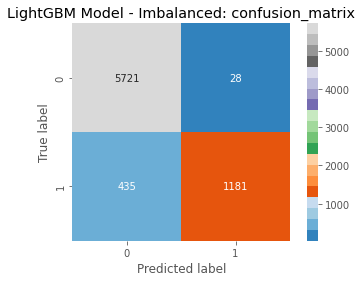

In [68]:
mat = confusion_matrix(y_test, y_pred_i_b)
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap='tab20c')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('LightGBM Model - Imbalanced: confusion_matrix');

LightGBM model - Imabalnced - AUC: 95.01475 %


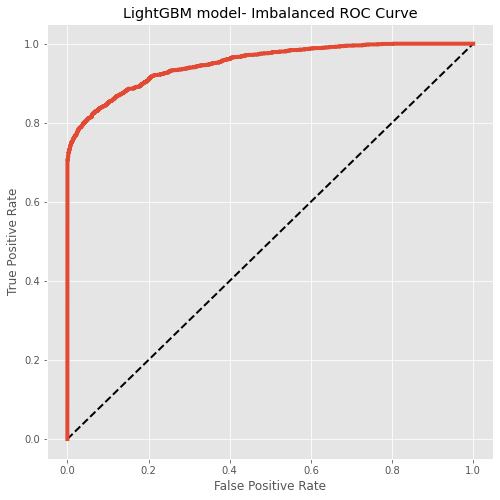

In [69]:
# Compute predicted probabilities: y_pred_prob:
y_pred_prob_i = lgb_i_b.predict_proba(X_test)[:,1]

print("LightGBM model - Imabalnced - AUC: {:0.5f}".format(roc_auc_score(y_test, y_pred_prob_i) * 100), "%")

# Generate ROC curve values: fpr, tpr, thresholds:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_i)
# Plot ROC curve:
plt.subplots(figsize = (8,8))
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.plot(fpr, tpr, label='LightGBM model', linewidth=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LightGBM model- Imbalanced ROC Curve')
plt.grid(True)
plt.show();

# Calculating AUC
The AUC value assesses how well a model can order observations from low probability to be target to high probability to be target. In Python, the roc_auc_score function can be used to calculate the AUC of the model. It takes the true values of the target and the predictions as arguments.

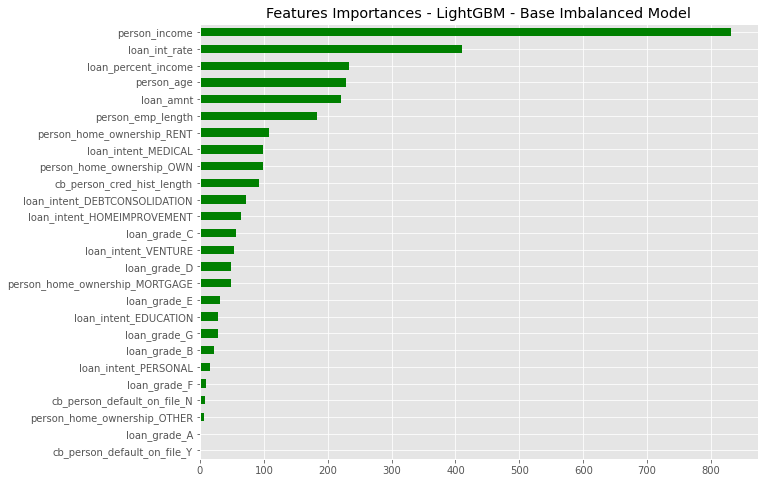

In [70]:
# First, let's create a pd.Series of features importances
importances_lgb_i_b = pd.Series(data=lgb_i_b.feature_importances_, index=X.columns)

# Sort importances
importances_sorted = importances_lgb_i_b.sort_values()

# Draw a horizontal barplot of importances_sorted
plt.figure(figsize=(10, 8))
importances_sorted.plot(kind='barh', color='green')
plt.title('Features Importances - LightGBM - Base Imbalanced Model')
plt.grid(True)
plt.show()

In this case, the most important variable is person_income,loan_int_rate,loan_percent_income,person_age and loan_amnt

# 5. One-Layer Stacking Classifier:
5.1 Fitting a One-Layer Stacking Classifier Model: Imbalanced Target Variable

In [71]:
from sklearn.ensemble import StackingClassifier

# Create below Classifiers: 
rfc_i_b = RandomForestClassifier(random_state = 1981)
xgbc_i_b = xgb.XGBClassifier(seed=1981)
lgbc_i_b = lgb.LGBMClassifier(random_state=1981)


# Get these models in a list
estimators = [('Random Forest', rfc_i_b),
              ('XGB', xgbc_i_b),
              ('lightGBM', lgbc_i_b)
             ]

#Stack these models with StackingClassifier
stacking = StackingClassifier(estimators=estimators, n_jobs =-1, verbose = 1,
                              final_estimator=LogisticRegression(random_state=1981))
                                       
                                       
# Fit the regressor to the training data
stacking.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


StackingClassifier(estimators=[('Random Forest',
                                RandomForestClassifier(random_state=1981)),
                               ('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None, gamma=None,
                                              gpu_id=None, grow_policy=None,
                                              importance_type=Non...
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None,
                                              reg_alpha=None, reg_lambda=None, ...)),
                               ('lightGBM', LGBMClassifier(random_state=1981))],
                   final_estimator=LogisticRegression(random_state=1981),
                   n_jobs=-1, verbose=1)

In [72]:
# Call predict() on entr_model with X_test passed to it, and assign the result to a variable y_pred_i_b 
y_pred_i_b = stacking.predict(X_test)

In [73]:
# Create predictions of probability for loan status using test data
preds_i_b = stacking.predict_proba(X_test)

# Create dataframes of first 20 predictions, and first 20 true labels
preds_df_i_b = pd.DataFrame(preds_i_b[:,1][0:20], columns = ['prob_default'])
true_df_i_b = y_test.head(20)

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df_i_b.reset_index(drop = True), preds_df_i_b], axis = 1))

    loan_status  prob_default
0             0             0
1             1             1
2             0             0
3             0             0
4             0             0
5             1             1
6             0             0
7             0             0
8             1             1
9             0             0
10            0             0
11            0             0
12            0             0
13            0             0
14            0             0
15            1             1
16            0             0
17            0             0
18            0             0
19            0             0


In [74]:
# Run this block for model evaluation metrics 
print("Stacking Model - Imbalanced")
print("Accuracy: {:0.5f}".format(metrics.accuracy_score(y_test,y_pred_i_b) *100), "%")
print('\n')
print("Stacking Model - Imbalanced: classification report")
print(classification_report(y_test, y_pred_i_b, digits=6))

Stacking Model - Imbalanced
Accuracy: 93.72709 %


Stacking Model - Imbalanced: classification report
              precision    recall  f1-score   support

           0   0.933148  0.990607  0.961019      5749
           1   0.957211  0.747525  0.839472      1616

    accuracy                       0.937271      7365
   macro avg   0.945179  0.869066  0.900246      7365
weighted avg   0.938427  0.937271  0.934350      7365



In [75]:
# Create a dataframe for the probabilities of default
preds_df_i_b = pd.DataFrame(preds_i_b[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
preds_df_i_b['loan_status'] = preds_df_i_b['prob_default'].apply(lambda x: 1 if x > 0.50 else 0)

print("Stacking Model - Imbalanced")
print("Accuracy: {:0.5f}".format(metrics.accuracy_score(y_test,y_pred_i_b) *100), "%")
print('********************************************************')

# Print the row counts for each loan status
print(preds_df_i_b['loan_status'].value_counts())
print('********************************************************')
# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df_i_b['loan_status'], target_names=target_names, digits=6))

Stacking Model - Imbalanced
Accuracy: 93.72709 %
********************************************************
0    6103
1    1262
Name: loan_status, dtype: int64
********************************************************
              precision    recall  f1-score   support

 Non-Default   0.933148  0.990607  0.961019      5749
     Default   0.957211  0.747525  0.839472      1616

    accuracy                       0.937271      7365
   macro avg   0.945179  0.869066  0.900246      7365
weighted avg   0.938427  0.937271  0.934350      7365



In [76]:
print('Stacking Model - Imabalanced: confusion_matrix')
print('\n')
print(pd.crosstab(y_test.ravel(), y_pred_i_b.ravel(), rownames = ['True'], colnames = ['Predicted'], margins = True))

Stacking Model - Imabalanced: confusion_matrix


Predicted     0     1   All
True                       
0          5695    54  5749
1           408  1208  1616
All        6103  1262  7365


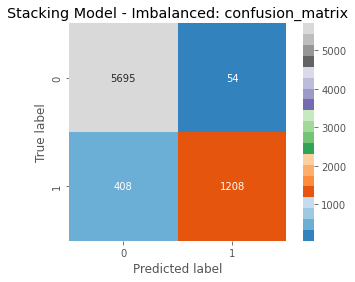

In [77]:
mat = confusion_matrix(y_test, y_pred_i_b)
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap='tab20c')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Stacking Model - Imbalanced: confusion_matrix');

Stacking model - Imabalnced - AUC: 95.28894 %


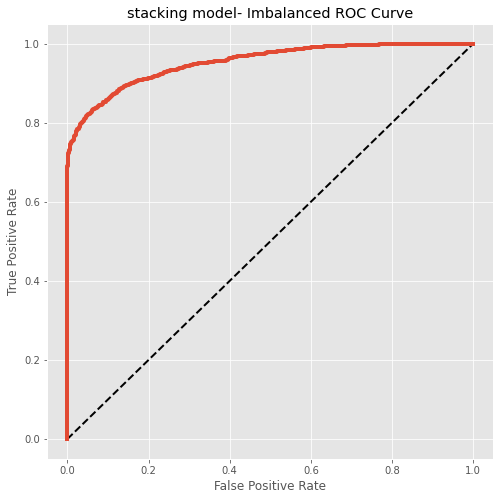

In [78]:
# Compute predicted probabilities: y_pred_prob:
y_pred_prob_i = stacking.predict_proba(X_test)[:,1]

print("Stacking model - Imabalnced - AUC: {:0.5f}".format(roc_auc_score(y_test, y_pred_prob_i) * 100), "%")

# Generate ROC curve values: fpr, tpr, thresholds:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_i)
# Plot ROC curve:
plt.subplots(figsize = (8,8))
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.plot(fpr, tpr, label='stacking model', linewidth=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('stacking model- Imbalanced ROC Curve')
plt.grid(True)
plt.show();

# Calculating AUC
The AUC value assesses how well a model can order observations from low probability to be target to high probability to be target. In Python, the roc_auc_score function can be used to calculate the AUC of the model. It takes the true values of the target and the predictions as arguments.

In [79]:
#### Optuna Hyperparameters Results: 
'''
logistic regression:
imbalanced:
BEST PARAMETERS : 
 {'logreg_max_iter': 600, 'logreg_solver': 'liblinear', 'logreg_class_weight': None}
balanced:
BEST PARAMETERS : 
 {'logreg_max_iter': 600, 'logreg_solver': 'saga', 'logreg_class_weight': None}

Random Forests:

imbalanced
BEST PARAMETERS : 
 {'rfc_n_estimators': 550, 'rfc_max_depth': 30, 'rfc_min_samples_split': 2, 'rfc_min_samples_leaf': 1, 'rfc_max_features': 'sqrt'}
balanced:
BEST PARAMETERS : 
 {'rfc_n_estimators': 500, 'rfc_max_depth': 28, 'rfc_min_samples_split': 2, 'rfc_min_samples_leaf': 1, 'rfc_max_features': 'log2'}

XGBoost
imbalanced
BEST PARAMETERS : 
 {'xgb_n_estimators': 700, 'xgb_max_depth': 10, 'xgb_learning_rate': 0.3, 'xgb_gamma': 0.35000000000000003, 'xgb_min_child_weight': 1, 'xgb_colsample_bytree': 0.75}
balanced:
BEST PARAMETERS : 
 {'xgb_n_estimators': 800, 'xgb_max_depth': 14, 'xgb_learning_rate': 0.3, 'xgb_gamma': 0.9500000000000001, 'xgb_min_child_weight': 1, 'xgb_colsample_bytree': 0.75}

LightGBM
imbalanced
BEST PARAMETERS : 
 {'lgb_n_estimators': 5000, 'lgb_learning_rate': 0.01, 'lgb_boosting_type': 'dart', 'lgb_reg_alpha': 1, 'lgb_reg_lambda': 1, 'lgb_colsample_bytree': 0.9}
Balanced:
BEST PARAMETERS : 
 {'lgb_n_estimators': 1000, 'lgb_learning_rate': 0.1, 'lgb_boosting_type': 'gbdt', 'lgb_reg_alpha': 0, 'lgb_reg_lambda': 0, 'lgb_colsample_bytree': 0.8}
 '''

"\nlogistic regression:\nimbalanced:\nBEST PARAMETERS : \n {'logreg_max_iter': 600, 'logreg_solver': 'liblinear', 'logreg_class_weight': None}\nbalanced:\nBEST PARAMETERS : \n {'logreg_max_iter': 600, 'logreg_solver': 'saga', 'logreg_class_weight': None}\n\nRandom Forests:\n\nimbalanced\nBEST PARAMETERS : \n {'rfc_n_estimators': 550, 'rfc_max_depth': 30, 'rfc_min_samples_split': 2, 'rfc_min_samples_leaf': 1, 'rfc_max_features': 'sqrt'}\nbalanced:\nBEST PARAMETERS : \n {'rfc_n_estimators': 500, 'rfc_max_depth': 28, 'rfc_min_samples_split': 2, 'rfc_min_samples_leaf': 1, 'rfc_max_features': 'log2'}\n\nXGBoost\nimbalanced\nBEST PARAMETERS : \n {'xgb_n_estimators': 700, 'xgb_max_depth': 10, 'xgb_learning_rate': 0.3, 'xgb_gamma': 0.35000000000000003, 'xgb_min_child_weight': 1, 'xgb_colsample_bytree': 0.75}\nbalanced:\nBEST PARAMETERS : \n {'xgb_n_estimators': 800, 'xgb_max_depth': 14, 'xgb_learning_rate': 0.3, 'xgb_gamma': 0.9500000000000001, 'xgb_min_child_weight': 1, 'xgb_colsample_bytree'

In [80]:
# Create below Classifiers: 
rfc_i_t = RandomForestClassifier(n_estimators=550, max_depth=30,min_samples_split=2,min_samples_leaf=1,max_features='sqrt',random_state = 1981)
xgbc_i_t = xgb.XGBClassifier(n_estimators=700, max_depth=10,learning_rate=0.3,gamma=0.35,min_child_weight=1,colsample_bytree=0.75,seed=1981)
lgbc_i_t = lgb.LGBMClassifier(n_estimators=5000, learning_rate=0.01,boosting_type='dart',reg_alpha=1,reg_lambda=1,colsample_bytree=0.9,random_state=1981)


# Get these models in a list
estimators_i_t = [('Random Forest', rfc_i_t),
              ('XGB', xgbc_i_t),
              ('lightGBM', lgbc_i_t)
             ]

#Stack these models with StackingClassifier
stacking_i_t = StackingClassifier(estimators=estimators_i_t, n_jobs =-1, verbose = 1,
                              final_estimator=LogisticRegression(max_iter=600, solver='liblinear',random_state=1981))
                                       
                                       
# Fit the regressor to the training data
stacking_i_t.fit(X_train, y_train)

# Call predict() on entr_model with X_test passed to it, and assign the result to a variable y_pred_i_b 
y_pred_i_t = stacking_i_t.predict(X_test)

print("Tuned One-Layer Stacking Model - Imbalanced")
print("Accuracy: {:0.5f}".format(metrics.accuracy_score(y_test,y_pred_i_t) *100), "%")

print('***********************************')
print('Tuned One-Layer Stacking Model - Imabalanced: confusion_matrix')
print(pd.crosstab(y_test.ravel(), y_pred_i_t.ravel(), rownames = ['True'], colnames = ['Predicted'], margins = True))
print('***********************************')
print(classification_report(y_test, y_pred_i_t, digits=6))
print('***********************************')
# Compute predicted probabilities: y_pred_prob:
y_pred_prob_i_t = stacking_i_t.predict_proba(X_test)[:,1]

print("Tuned One-Layer Stacking model - Imabalnced - AUC: {:0.5f}".format(roc_auc_score(y_test, y_pred_prob_i_t) * 100), "%")


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.6s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.9s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min finished


Tuned One-Layer Stacking Model - Imbalanced
Accuracy: 93.80855 %
***********************************
Tuned One-Layer Stacking Model - Imabalanced: confusion_matrix
Predicted     0     1   All
True                       
0          5688    61  5749
1           395  1221  1616
All        6083  1282  7365
***********************************
              precision    recall  f1-score   support

           0   0.935065  0.989389  0.961460      5749
           1   0.952418  0.755569  0.842650      1616

    accuracy                       0.938086      7365
   macro avg   0.943742  0.872479  0.902055      7365
weighted avg   0.938872  0.938086  0.935392      7365

***********************************
Tuned One-Layer Stacking model - Imabalnced - AUC: 95.14763 %


# 7.1 Tunded Multi-Layer Stacking Classifier: Imbalanced Target Variable

In [135]:
# Create below Classifiers: 
rfc_i_t = RandomForestClassifier(n_estimators=550, max_depth=30,min_samples_split=2,min_samples_leaf=1,max_features='sqrt',random_state = 1981)
xgbc_i_t = xgb.XGBClassifier(n_estimators=700, max_depth=10,learning_rate=0.3,gamma=0.35,min_child_weight=1,colsample_bytree=0.75,seed=1981)
lgbc_i_t = lgb.LGBMClassifier(n_estimators=5000, learning_rate=0.01,boosting_type='dart',reg_alpha=1,reg_lambda=1,colsample_bytree=0.9,random_state=1981)


# Get these models in a list
layer_One_estimator_i_t = [('Random Forest', rfc_i_t),
                           ('lightGBM', lgbc_i_t)
                          ]

layer_Two_estimator_i_t = [
                           ('XGB', xgbc_i_t),
                           ('lightGBM', lgbc_i_t)
                          ]

layer_two = StackingClassifier(estimators=layer_Two_estimator_i_t, final_estimator=LogisticRegression(max_iter=600, solver='liblinear',random_state=1981))

#Stack these models with StackingClassifier
final_stacking_i_t = StackingClassifier(estimators=layer_One_estimator_i_t, n_jobs =-1, verbose = 1,
                                        final_estimator=layer_two)
                                       
                                       
# Fit the regressor to the training data
final_stacking_i_t.fit(X_train, y_train)

# Call predict() on entr_model with X_test passed to it, and assign the result to a variable y_pred_i_b 
y_pred_i_t = final_stacking_i_t.predict(X_test)

print("Tuned Multi-Layer Stacking Model - Imbalanced")
print("Accuracy: {:0.5f}".format(metrics.accuracy_score(y_test,y_pred_i_t) *100), "%")

print('***********************************')
print('Tuned Multi-Layer Stacking Model - Imabalanced: confusion_matrix')
print(pd.crosstab(y_test.ravel(), y_pred_i_t.ravel(), rownames = ['True'], colnames = ['Predicted'], margins = True))
print('***********************************')
print(classification_report(y_test, y_pred_i_t, digits=6))
print('***********************************')
# Compute predicted probabilities: y_pred_prob:
y_pred_prob_i_t = stacking_i_t.predict_proba(X_test)[:,1]

print("Tuned Multi-Layer Stacking model - Imabalnced - AUC: {:0.5f}".format(roc_auc_score(y_test, y_pred_prob_i_t) * 100), "%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.1s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.8min finished


Tuned Multi-Layer Stacking Model - Imbalanced
Accuracy: 94.13442 %
***********************************
Tuned Multi-Layer Stacking Model - Imabalanced: confusion_matrix
Predicted     0     1   All
True                       
0          5679    70  5749
1           362  1254  1616
All        6041  1324  7365
***********************************
              precision    recall  f1-score   support

           0   0.940076  0.987824  0.963359      5749
           1   0.947130  0.775990  0.853061      1616

    accuracy                       0.941344      7365
   macro avg   0.943603  0.881907  0.908210      7365
weighted avg   0.941624  0.941344  0.939158      7365

***********************************
Tuned Multi-Layer Stacking model - Imabalnced - AUC: 96.82242 %


# Make Final Predictions

Section Goals

Determine which model performed the best on the test dataset

# Model Results is in the folder


# Next Steps

Section Goals

1.Read in the new dataset with unknown loan status information and process through previously created pipeline

2.Train the best-performing model on the entire dataset where we have known loan status information

3.Make predictions on the new dataset

4.Use predictions to make recommendations about which loan application to approve or reject